In [14]:

import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline



from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


In [17]:
import numpy as np

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
master_df = pd.read_csv('/content/drive/My Drive/sample30.csv')

In [8]:
df=master_df.copy()
df.sample(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
27995,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-04-04T00:00:00.000Z,NaN,True,5,The kids really enjoyed this movie. They loved...,kids loved this movie,NaN,NaN,johnny99,Positive
10359,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-26T00:00:00.000Z,False,True,5,"I've tried several brands, but Clorox wipes ar...",Best wipes out there!,NaN,NaN,juliet,Positive
11565,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-02T00:00:00.000Z,False,True,5,Clorox is a product I would not change for any...,My Clorox,NaN,NaN,chubbycheeks,Positive
25393,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-10-18T00:00:00.000Z,NaN,True,5,The King of Monsters has returned!!! Looking f...,He's Back!!!,NaN,NaN,kharmo88,Negative
22853,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2014-09-09T00:00:00.000Z,True,True,5,I have used Bisquick since I got married in 19...,You cannot buy a better bisquit mix.,NaN,NaN,txpalnoshopper,Positive


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [10]:
### Total reviews
total = len(df['reviews_text'])
print ("Number of reviews: ",total)

### Unique reviewers
print ("Number of unique reviewers: ",len(df['reviews_username'].unique()))
reviewer_prop = float(len(df['reviews_username'].unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))

### Average star score
print ("Average rating score: ",round(df['reviews_rating'].mean(),3))

Number of reviews:  30000
Number of unique reviewers:  24915
Prop of unique reviewers:  0.831
Average rating score:  4.483


In [11]:
#data overivew
print('rows: ', df.shape[0])
print('columns: ', df.shape[1])
print('\nfeatures: ', df.columns.to_list())
print('\nmissing vlues: ', df.isnull().values.sum())
print('\nUnique values: \n', df.nunique())


rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


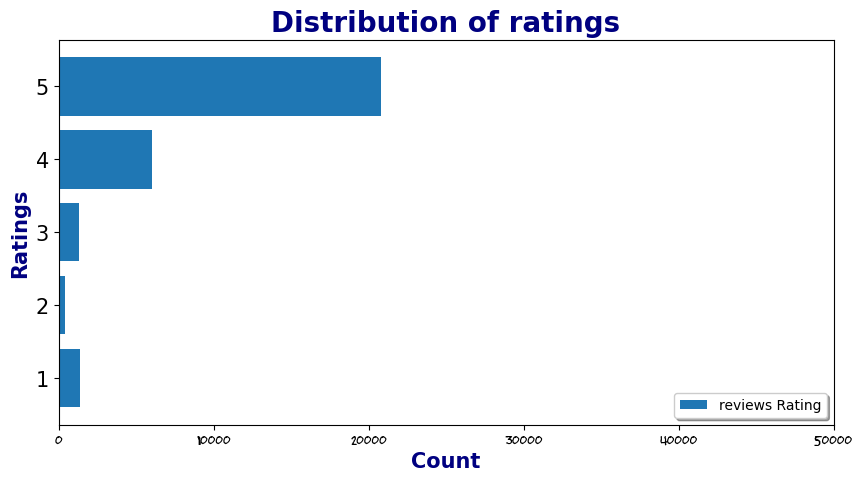

In [18]:

# Number of occurences for each rating
#plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(df['reviews_rating'].value_counts().index)
y = list(df['reviews_rating'].value_counts())
plt.barh(x, y)
ticks_x = np.linspace(0, 50000, 6) # (start, end, no of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks(size=15)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.legend(['reviews Rating'], shadow=True, loc=4)

<ipython-input-19-820d23173095>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





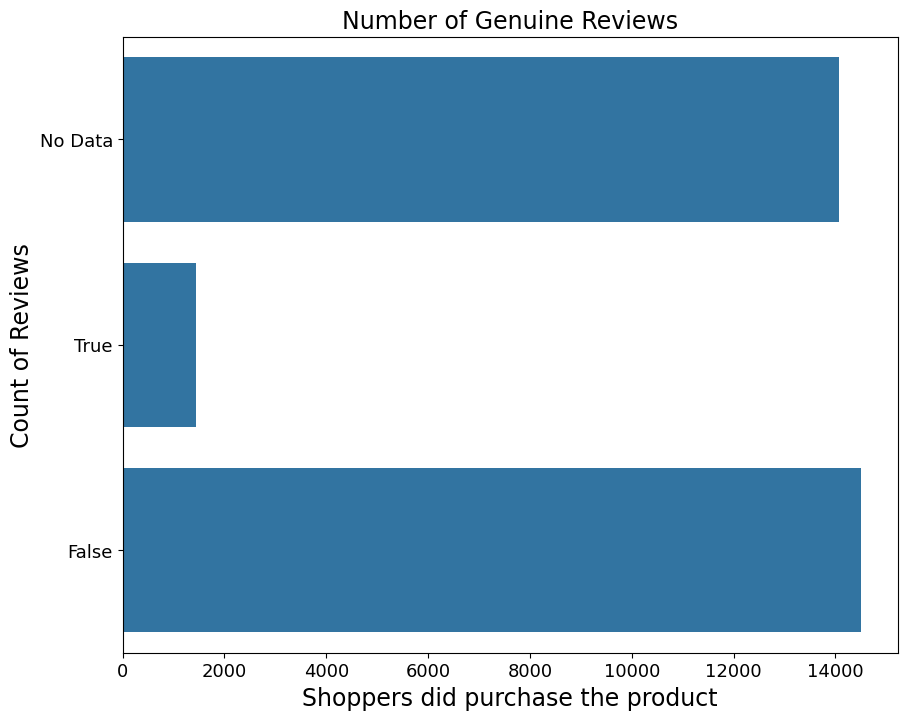

In [19]:
# Number of Postive and Negatives in the data frame showing the class imbalance
#Replace the Nan values to No Data for reviewers did purchase or not
df['reviews_didPurchase'].fillna('No Data', inplace=True)
#Distribution of reviews for actual purchasing customers
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of Genuine Reviews', fontsize=17)
ax.tick_params(labelsize=13)

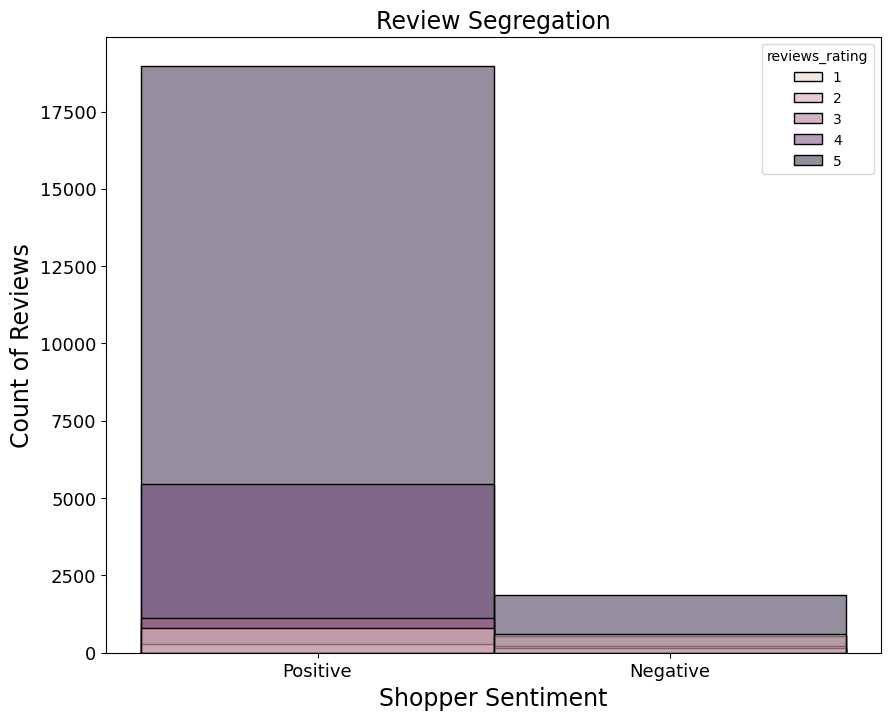

In [20]:
# To see any corrections are required in the dataframe is required using rating and user sentiment

plt.figure(figsize=(10,8))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="Shopper Sentiment", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Review Segregation', fontsize=17)
ax.tick_params(labelsize=13)

In [21]:
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [22]:
# To download the stopwords from NLTK library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
#preserving important stop words that could have impact in reviews
preserve_stopwords = {
    "not", "no", "never", "nothing", "none",
    "can't", "doesn't", "isn't", "don't",
    "won't", "wasn't", "aren't", "hasn't",
    "couldn't", "wouldn't", "very", "extremely",
    "so", "too", "quite", "pretty", "slightly",
    "incredibly", "absolutely", "highly", "better",
    "best", "worse", "worst", "feel", "think",
    "believe", "prefer", "hope", "really",
    "actually", "literally", "surely", "probably",
    "might", "would", "should",  "if", "whether"
}

In [32]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words - preserve_stopwords


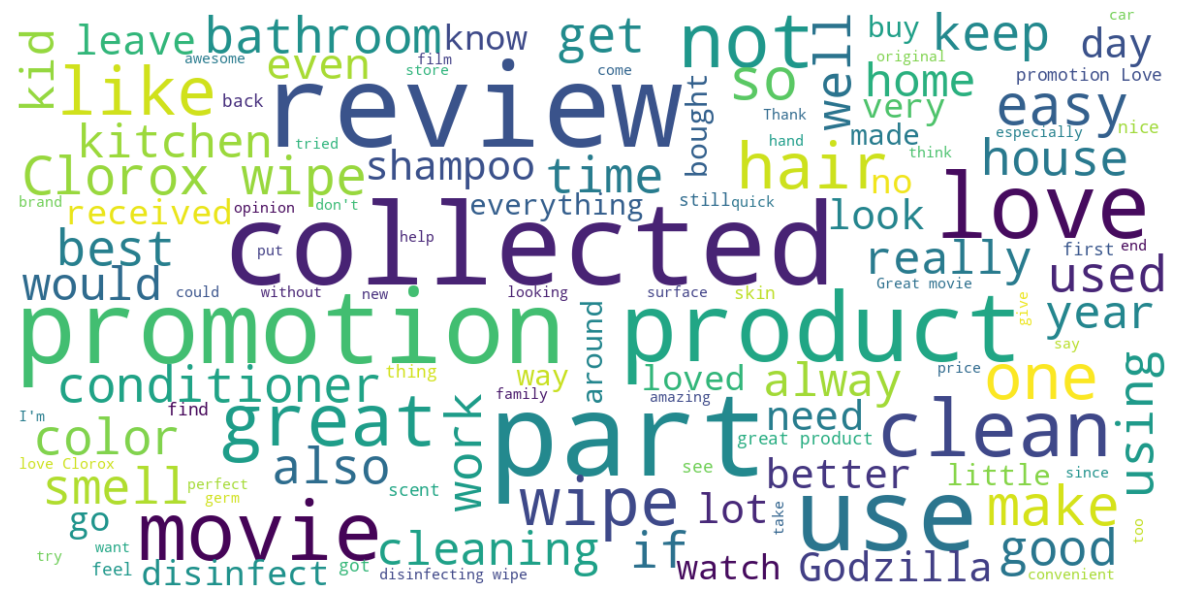

In [33]:
# To Check the most word occurence using word cloud
from wordcloud import WordCloud

reviews_text = ' '.join(df['reviews_text'].dropna())  # Drop NaN if there are any missing reviews

wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(reviews_text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Cleaning

In [34]:

# Finding the number of rows with Null values
df.isnull().sum()

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,0
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [35]:

#shape of the dataframe
df.shape

(30000, 15)

In [36]:
#From the null values percentages, columns reviews_userCity and reviews_userProvince can be dropped
df = df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [37]:

# Finding the number of rows with Null values
print("shape of the dataframe =",df.shape)
df.isnull().sum()/len(df)

shape of the dataframe = (30000, 13)


,0
id,0.000000
brand,0.000000
categories,0.000000
manufacturer,0.004700
name,0.000000
reviews_date,0.001533
reviews_didPurchase,0.000000
reviews_doRecommend,0.085667
reviews_rating,0.000000
reviews_text,0.000000


In [38]:
# Before Updating the user sentiment columns
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [39]:
# for correcting the user sentiment according to rating
def review_sentiment_clear(x):
  if x >= 3 :
    return 'Postive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [40]:
df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Postive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Postive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Postive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [41]:

# After corrections for user sentiment
df['user_sentiment'].value_counts()

,count
user_sentiment,
Postive,28196
Negative,1804


### Text Preprocessing

In [43]:

#Common functions for cleaning the text data
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import html

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= list(stop_words)

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:

def normalize_and_lemmaize(input_text):
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)


In [46]:
# Take the Review comment and user sentiment as dataframe
review_df = df[['reviews_text','user_sentiment']]
review_df.head(10)

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Postive
1,Good flavor. This review was collected as part...,Postive
2,Good flavor.,Postive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative
5,My boyfriend and I bought this to spice things...,Negative
6,Bought this earlier today and was excited to c...,Negative
7,I bought this product for my husband and I to ...,Negative
8,My husband and I bought this for some extra fu...,Negative
9,Got as a surprise for my husband there is noth...,Negative


In [49]:
# create a new column lemmatized_review using the emmatize_text function

nltk.download('punkt_tab')

review_df['lemmatized_text'] = review_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))
review_df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-49-31ea1999cbb7>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the...,Postive,love album very good hip hop side current pop ...
1,Good flavor. This review was collected as part...,Postive,good flavor review collect part promotion
2,Good flavor.,Postive,good flavor
3,I read through the reviews on here before look...,Negative,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,Negative,husband buy gel us gel cause irritation felt l...


In [50]:
# new dataframe with lemmatized text and user sentiment
review_new_df = review_df[['lemmatized_text','user_sentiment']]
review_new_df

,lemmatized_text,user_sentiment
0,love album very good hip hop side current pop ...,Postive
1,good flavor review collect part promotion,Postive
2,good flavor,Postive
3,read review look buy one couple lubricants ult...,Negative
4,husband buy gel us gel cause irritation felt l...,Negative
...,...,...
29995,get conditioner influenster try im love so far...,Postive
29996,love receive review purpose influenster leave ...,Postive
29997,first love smell product wash hair so smooth e...,Postive
29998,receive influenster never go back anything els...,Postive


In [51]:

#Encode the negative and postive to 0 and 1 respectively
review_new_df['user_sentiment'] = review_new_df['user_sentiment'].map({'Negative':0,'Postive':1})
review_new_df.head()

<ipython-input-51-1bdb48edae9e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lemmatized_text,user_sentiment
0,love album very good hip hop side current pop ...,1
1,good flavor review collect part promotion,1
2,good flavor,1
3,read review look buy one couple lubricants ult...,0
4,husband buy gel us gel cause irritation felt l...,0



### Dividing the dataset into train and test data and handle the class imbalance

In [52]:
from collections import Counter
from imblearn.over_sampling import SMOTE


In [53]:

# Train and Test Divide
x_train,x_test,y_train,y_test = train_test_split(review_new_df['lemmatized_text'],review_new_df['user_sentiment'],train_size=0.75,random_state=45,stratify=review_new_df['user_sentiment'])
y_train.value_counts()


,count
user_sentiment,
1,21147
0,1353


### Feature Extraction using Count Vectorizer and TFIDF Transformer

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
x_count = count_vect.fit_transform(x_train)


tfidf_transformer = TfidfTransformer()
x_train_transformed = tfidf_transformer.fit_transform(x_count)
x_train_transformed.shape


(22500, 14761)

In [56]:
count = Counter(y_train)
print('Before sampling :',count)

sampler = SMOTE()

x_train_sm,y_train_sm = sampler.fit_resample(x_train_transformed,y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1: 21147, 0: 1353})
After sampling : Counter({1: 21147, 0: 21147})


### Training text classification model
* Logistic Regression
* Random Forest Classifer
* XGBoost <br>
Choose the best model with hyperparameter tuning

In [58]:
# Function for Metrics
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics


## Logistic Regression

In [59]:
# 1. Logsitic Regression
lr = LogisticRegression()
lr.fit(x_train_sm,y_train_sm)

LogisticRegression()

In [62]:
y_pred = lr.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[20801   346]
 [  648 20499]]
sensitivity of the Logistic Regression = 0.970000
specificity of the Logistic Regression = 0.980000
Accuracy Score of Logistic Regression = 0.976498
ROC AUC score of Logistic Regression = 0.976498
Report=
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21147
           1       0.98      0.97      0.98     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294

**************************************************


## Random Forest Classifier

In [64]:

# 2. RandomForest Classifier
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)

RandomForestClassifier()

In [65]:
y_pred_rf = rf.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[21146     1]
 [    1 21146]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 0.999953
ROC AUC score of RandomForestClassifier = 0.999953
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


## AdaBoost Classifier

In [66]:
xgba = GradientBoostingClassifier()
xgba.fit(x_train_sm,y_train_sm)
y_pred_xgb = xgba.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_rf,'AdaBoostclassifier',peformance)

**************************************************
Confusion Matrix =
[[21146     1]
 [    1 21146]]
sensitivity of the AdaBoostclassifier = 1.000000
specificity of the AdaBoostclassifier = 1.000000
Accuracy Score of AdaBoostclassifier = 0.999953
ROC AUC score of AdaBoostclassifier = 0.999953
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


## XGBoost

In [67]:
#4.XGBoostClassifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_sm,y_train_sm)
y_pred_xgbc = xgb_classifier.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbc,'XGBClassifier',peformance)

**************************************************
Confusion Matrix =
[[20878   269]
 [  127 21020]]
sensitivity of the XGBClassifier = 0.990000
specificity of the XGBClassifier = 0.990000
Accuracy Score of XGBClassifier = 0.990637
ROC AUC score of XGBClassifier = 0.990637
Report=
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21147
           1       0.99      0.99      0.99     21147

    accuracy                           0.99     42294
   macro avg       0.99      0.99      0.99     42294
weighted avg       0.99      0.99      0.99     42294

**************************************************


In [68]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.976498,0.976498,0.983401,0.976329
1,RandomForestClassifier,0.999953,0.999953,0.999953,0.999953
2,AdaBoostclassifier,0.999953,0.999953,0.999953,0.999953
3,XGBClassifier,0.990637,0.990637,0.987364,0.990668


### Recommendation System

### User User Recommendation

In [69]:
df = pd.read_csv('/content/drive/My Drive/sample30.csv')

In [70]:
len(df['name'].unique())

271

In [71]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.70,random_state=45)
print('train shape = ',train.shape)
print('test shape = ',test.shape)

train shape =  (21000, 15)
test shape =  (9000, 15)


In [72]:
#using train dataset and create correlation matrix
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)
train_pivot

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zwithanx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [74]:
#Creating the train and test dataset for predicting and evaluating the correlation
#fill 1 in place of Nan for prediction
train_pivot1 = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)

In [76]:
train_pivot1.loc['rebecca']

,rebecca
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0
100:Complete First Season (blu-Ray),1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0
...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0
Weleda Everon Lip Balm,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0


In [77]:
# here we are going use the adjusted cosine similarity
import numpy as np

def cosine_similarity(df):
    # using the adjusted cosine similarity
    mean_df = np.nanmean(df,axis=1)
    substracted_df = (df.T - mean_df).T # Normalized dataset
    # using the pairwise_distance for cosine similarity
    user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    return user_correlation,substracted_df

In [78]:

user_corr_matrix,normalized_df = cosine_similarity(train_pivot1)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [79]:
user_corr_matrix.shape


(18205, 18205)

In [80]:
user_corr_matrix[user_corr_matrix < 0] = 0
user_corr_matrix.shape

(18205, 18205)

In [81]:
df[df['reviews_username'] == 'rebecca']


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
397,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-01-20T00:00:00.000Z,False,True,5,"I LOVE this product, but for some reason I'm n...",Rebecca,NaN,NaN,rebecca,Positive
6290,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...",Hormel,"Hormel Chili, No Beans",2015-09-08T00:00:00.000Z,False,True,3,Good on chili dogs!,yummm,NaN,NaN,rebecca,Positive
14279,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-22T00:00:00.000Z,False,True,5,"this is just so easy to use, and to know that ...",LOVE THIS,NaN,NaN,rebecca,Positive
18469,AVpfIfnYilAPnD_xVpGi,Soothing Touch,"Personal Care,Makeup,Lipstick, Lip Gloss, & Li...",Soothing Touch,Soothing Touch Lemon Cardamom Vegan Lip Balm ....,2016-04-25T00:00:00Z,NaN,NaN,5,"Cant beat these! Smooth, flavorful and soothin...",NaN,NaN,NaN,rebecca,Positive
21129,AVpfM_ytilAPnD_xXIJb,Tostitos,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Tostitos,Tostitos Bite Size Tortilla Chips,2016-11-16T00:00:00.000Z,True,True,5,I love these chips. They pair perfectly with a...,Tostitos Bite Size Rounds,NaN,NaN,rebecca,Positive
28288,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,My son LOVES this movie.. And to tell you the ...,Excellent movie!,NaN,NaN,rebecca,Positive
28808,AVpfVPh3ilAPnD_xZzW9,Mrs. Meyer's,"Household Chemicals,Household Cleaners,Glass a...",Mrs. Meyers,Mrs. Meyer's Lemon Verbena Surface Scrub,2011-06-24T00:00:00.000Z,False,True,5,This is my favorite cleanser. I use it to scru...,My favorite!,NaN,NaN,rebecca,Positive


In [82]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot1.fillna(0))
user_pred_ratings

array([[ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       ...,
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386]])

In [83]:
user_pred_ratings.shape


(18205, 254)

In [84]:
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,437.755764,438.269950,437.755764,437.755764,440.056019,437.755764,437.755764,437.755764,437.755764,441.303557,...,437.755764,437.755764,437.755764,437.755764,438.873393,437.755764,437.755764,443.401427,440.056019,437.755764
02dakota,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
02deuce,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
0325home,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
06stidriver,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,456.106425,458.597546,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,461.356739,...,457.883951,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,459.712962,456.106425,456.106425
zwithanx,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
zxcsdfd,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525


In [87]:
d = user_final_rating
d.loc['rebecca'].sort_values(ascending=False)[:20]

,rebecca
name,
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),9711.054666
Olay Regenerist Deep Hydration Regenerating Cream,7080.603624
Tostitos Bite Size Tortilla Chips,4699.282584
Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,3304.904920
"Hormel Chili, No Beans",2250.193038
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,714.951814
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,678.992207
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),672.800711
Mike Dave Need Wedding Dates (dvd + Digital),668.332888


### Evaluation for user-user recommendation system

In [88]:

## Evaluation
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape


(2006, 15)

In [89]:
corr_df = pd.DataFrame(user_corr_matrix)


In [90]:
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18202,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18203,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [91]:

corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df


,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zwithanx,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
zxcsdfd,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [92]:
list_name = common.reviews_username.tolist()


In [94]:
corr_df.columns = normalized_df.index.tolist()
corr_df.columns


Index(['00sab00', '02dakota', '02deuce', '0325home', '06stidriver', '1.11E+24',
       '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa', '11677j',
       ...
       'zowie', 'zozo0o', 'zsazsa', 'zt313', 'zubb', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzdiane'],
      dtype='object', length=18205)

In [95]:
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [96]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()


,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,0.0,0.223114,0.0,0.511718,0.0,0.0,0.837534,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278697
123charlie,0.684558,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.656818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
143st,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1943,0.223114,0.000000,0.0,1.000000,0.0,0.444381,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242522
4cloroxl,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [97]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)

In [98]:
common_user_tb


name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating


array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [102]:

dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test


name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings


name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:695: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:712: RuntimeWarning:

All-NaN slice encountered



(1687, 120)

In [105]:
total_non_nan = np.count_nonzero(~np.isnan(y))


In [106]:
total_non_nan


1787

In [107]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
rmse = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)


1.8755890184650454


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



### Item and Item recommendation system


In [109]:
train_pivot_ii = train_pivot1.T
train_pivot_ii


reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Weleda Everon Lip Balm,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [111]:

item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_ii)
item_corr_matrix.shape


(254, 254)

In [112]:
item_pred_rating = np.dot((train_pivot_ii.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating


array([[1.04268435, 0.82942606, 0.90407857, ..., 0.8340146 , 0.81433002,
        0.79418324],
       [1.02447686, 0.82044582, 0.89224956, ..., 0.75605699, 0.74593788,
        0.77182255],
       [1.03032533, 0.82731907, 0.89604918, ..., 0.7795106 , 0.76225108,
        0.78034392],
       ...,
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.03749796, 0.8109133 , 0.90070908, ..., 0.81815776, 0.81746936,
        0.78245846]])

In [113]:

#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.042684,0.829426,0.904079,0.865297,1.257602,0.864404,0.932152,0.904079,0.904079,0.776925,...,0.629687,0.904079,0.948084,0.932152,0.987044,0.786945,0.874076,0.834015,0.814330,0.794183
02dakota,1.024477,0.820446,0.892250,0.848678,1.146304,0.847674,0.923788,0.892250,0.892250,0.739312,...,0.566040,0.892250,0.999030,0.923788,0.998108,0.760634,0.858542,0.756057,0.745938,0.771823
02deuce,1.030325,0.827319,0.896049,0.854016,1.148991,0.853048,0.926475,0.896049,0.896049,0.748478,...,0.586484,0.896049,0.987127,0.926475,0.988945,0.769085,0.863532,0.779511,0.762251,0.780344
0325home,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
06stidriver,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.037404,0.821633,0.900648,0.860477,1.152243,0.859552,0.929727,0.900648,0.900648,0.779304,...,0.624816,0.900648,0.944688,0.929727,0.953126,0.779314,0.869571,0.812825,0.781995,0.782245
zwithanx,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
zxcsdfd,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271


In [114]:
d_item = item_final_rating
d_item.loc['rebecca'].sort_values(ascending=False)[:20]


,rebecca
name,
Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,30.358063
Tostitos Bite Size Tortilla Chips,30.197257
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),21.140923
Olay Regenerist Deep Hydration Regenerating Cream,18.680224
"Hormel Chili, No Beans",8.674749
Cantu Coconut Milk Shine Hold Mist - 8oz,2.747752
"Newman's Own Organics Licorice Twist, Black 5oz",2.482956
Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,2.467184
Naturtint Nutrideep Multiplier Protective Cream,2.410967


### Evaluation for item and item

In [115]:
common_item = test[test.name.isin(train.name)]
common_item


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and s...",Clorox Rocks,NaN,NaN,briley,Positive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,you can do sooooo much with this product..bisc...,Alot of a good thing!!!,NaN,NaN,foxfire61,Positive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know...,Keep Cancer Home Germ Free,NaN,NaN,margies,Positive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2015-08-18T00:00:00.000Z,False,False,1,Windex used to be the best but whatever they h...,no longer a good glass cleaner,NaN,NaN,mel,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their ...,Great In Showers,NaN,NaN,jillybeansoccermom,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28158,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,Great family movie. My kids loved it. Goes goo...,great movie,NaN,NaN,tony,Positive
7350,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-28T00:00:00.000Z,False,True,4,Good product and very convenient to have aroun...,convenient,NaN,NaN,heggemister,Positive
16974,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-09-17T00:00:00.000Z,NaN,NaN,5,THIS RICE IS THE ONLY ONE I EAT AT HOME. SO NU...,Five Stars,NaN,NaN,byindubstylo,Negative
19418,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,i use the clorox wipes for everything. they ar...,great for anything,NaN,NaN,nack101,Positive


In [116]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T

common_item_pivot.shape


(206, 8379)

In [117]:

item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df


,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
1,-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
3,-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4,-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
250,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
251,-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642
252,-0.000726,-0.003313,-0.000472,-0.000663,0.170716,-0.000667,-0.000334,-0.000472,-0.000472,-0.003203,...,-0.002538,-0.000472,-0.000467,-0.000334,-0.000578,-0.001049,-0.000619,-0.004494,1.000000,-0.001641


In [118]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [119]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df


,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [120]:

list_items


['Clorox Disinfecting Bathroom Cleaner',
 'Bisquick Original Pancake And Baking Mix - 40oz',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Clorox Disinfecting Bathroom Cleaner',
 'Clorox Disinfecting Bathroom Cleaner',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Clorox Disinfecting Bathroom Cleaner',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Jason Aldean - They Don't Know",
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Sc

In [121]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1


,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,-0.000110,1.000000,-0.000110,-0.000155,-0.000155,-0.001055,...,-0.000836,-0.000155,-0.000154,-0.000110,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [122]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3


,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000239,-0.000169,-0.000169,-0.001148,-0.000337,-0.000167,...,-0.001036,-0.000910,-0.000169,-0.000167,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.001091,-0.000772,-0.000772,-0.005241,-0.001538,-0.000764,...,-0.004725,-0.004152,-0.000772,-0.000764,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000155,-0.000110,-0.000110,-0.000746,-0.000219,-0.000109,...,-0.000673,-0.000591,-0.000110,-0.000109,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000218,-0.000154,-0.000154,-0.001048,-0.000308,-0.000153,...,-0.000945,-0.000831,-0.000154,-0.000153,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,1.000000,-0.000155,-0.000155,-0.001055,-0.000310,-0.000154,...,-0.000951,-0.000836,-0.000155,-0.000154,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000346,-0.000244,-0.000244,-0.001660,-0.000487,-0.000242,...,-0.001496,-0.001315,-0.000244,-0.000242,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000204,-0.000144,-0.000144,-0.000980,-0.000288,-0.000143,...,-0.000884,-0.000776,-0.000144,-0.000143,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.001480,-0.001047,-0.001047,0.002321,-0.002086,-0.001036,...,0.003016,-0.005632,-0.001047,-0.001036,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [123]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape


(206, 8379)

In [124]:
test_items = common_item.copy()


In [125]:

test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings


reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape


MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(206, 8379)

In [127]:
total_non_nan = np.count_nonzero(~np.isnan(y))


In [128]:
rmse = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

3.5541206040111435


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



### Best suited recommendation system
By checking the root mean squared error for user-user and item-item recommendation systems ,
## User-User recommendation
will be used as it is having less RMSE

### Improving the recommendations using the sentiment analysis model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

def recommend_top_products(user_id, df, top_n=5):

    # Create a pivot table with users as rows, products as columns, and ratings as values
    train_pivot = pd.pivot_table(
        data=df,
        index='reviews_username',
        columns='name',
        values='reviews_rating'
    ).fillna(1)

    # Calculate adjusted cosine similarity
    mean_ratings = np.nanmean(train_pivot, axis=1)
    normalized_df = (train_pivot.T - mean_ratings).T
    user_corr_matrix = 1 - pairwise_distances(normalized_df.fillna(0), metric='cosine')
    user_corr_matrix[np.isnan(user_corr_matrix)] = 0

    # Predict user ratings
    user_pred_ratings = np.dot(user_corr_matrix, train_pivot.fillna(0))

    # Multiply predictions with the original ratings to adjust for the user's preferences
    user_final_rating = np.multiply(user_pred_ratings, train_pivot)

    # Retrieve recommendations for the given user
    if user_id not in user_final_rating.index:
        raise ValueError(f"User '{user_id}' not found in the dataset.")

    recommended_products = user_final_rating.loc[user_id].sort_values(ascending=False)
    return recommended_products[:top_n]


top_products = recommend_top_products('rebecca', df, top_n=5)
print(top_products)
